# Webscraping

#### Obtaining the data is the most tedious part of the project.
#### But alas, no data collection makes no project. 

#### We go to tfrrs.org and navigate to the Outdoor Big Ten lists and Outdoor Big Ten Championships. 
#### Having done that, we right click and press "Inspect" to find some information about the raw HTML from the webpage. 
#### But first, let's save all the links to the Big Ten lists and championships into two dictionaries. 


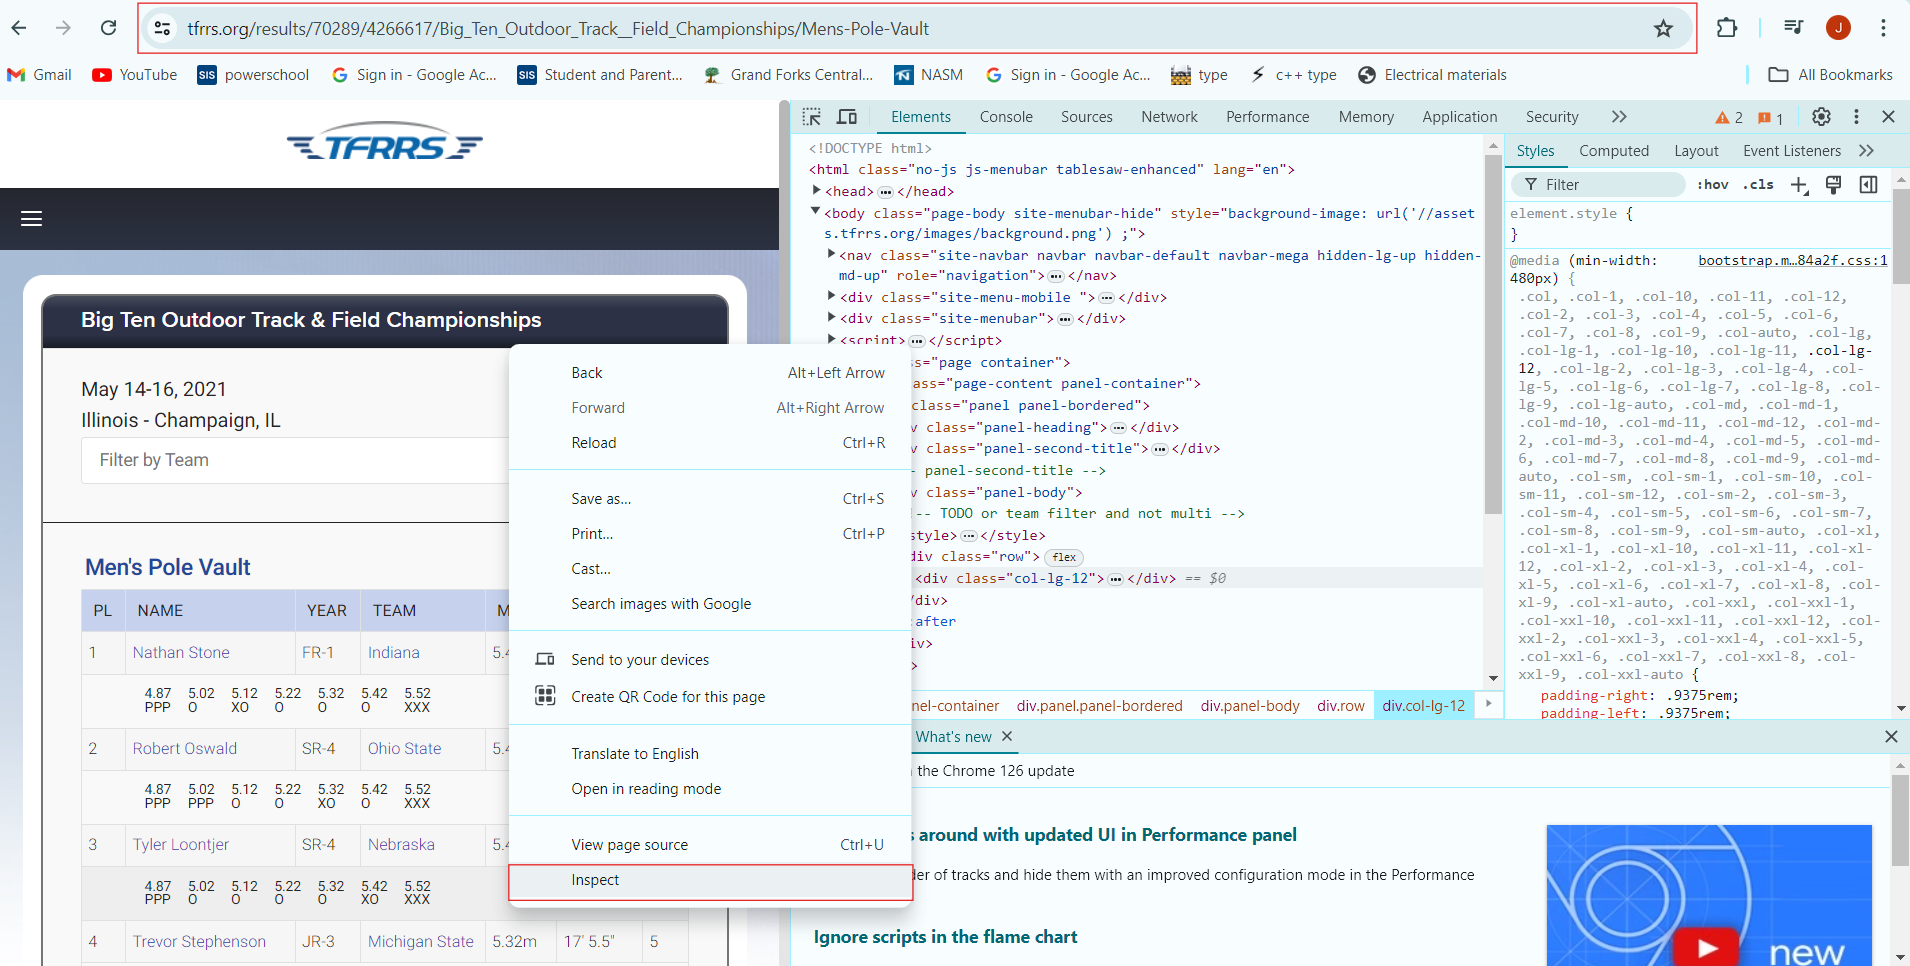

## We're going to want to copy paste the webpage link shown on top.
## Pressing "inspect" opens the HTML to the right.

In [1]:

links_lists = {
    2024 : "https://www.tfrrs.org/lists/4759/Big_Ten_Outdoor_Performance_List",
    2023 : "https://www.tfrrs.org/lists/4229/Big_Ten_Outdoor_Performance_List",
    2022 : "https://www.tfrrs.org/lists/3867/Big_Ten_Outdoor_Performance_List",
    2021 : "https://www.tfrrs.org/lists/3367/Big_Ten_Outdoor_Performance_List",
    2019 : "https://www.tfrrs.org/lists/2657/Big_Ten_Outdoor_Performance_List",
    2018 : "https://www.tfrrs.org/lists/2253/Big_Ten_Outdoor_Performance_Lis",
    2017 : "https://www.tfrrs.org/lists/2005/Big_Ten_Outdoor_Performance_List",
    2016 : "https://www.tfrrs.org/lists/1699/Big_Ten_Outdoor_Performance_List",
    2015 : "https://www.tfrrs.org/lists/1530/Big_Ten_Outdoor_Performance_List",
    2014 : "https://www.tfrrs.org/lists/1288/Big_Ten_Outdoor_Performance_List",
    2013 : "https://www.tfrrs.org/lists/1083/Big_Ten_Outdoor_Performance_List",
    2012 : "https://www.tfrrs.org/lists/925/Big_Ten_Outdoor_Performance_List",
    2011 : "https://www.tfrrs.org/lists/736/Big_Ten_Outdoor_Performance_List",
    2010 : "https://www.tfrrs.org/lists/570/Big_Ten_Outdoor_Performance_List"
}

links_champs = { 
    2024 : "https://www.tfrrs.org/results/86945/5277351/Big_Ten_Outdoor_Championships/Mens-Pole-Vault",
    2023 : "https://www.tfrrs.org/results/81218/4928785/Big_Ten_Outdoor_Championships/Mens-Pole-Vault",
    2022 : "https://www.tfrrs.org/results/75158/4559902/Big_Ten_Outdoor_Track__Field_Championships/Mens-Pole-Vault",
    2021 : "https://www.tfrrs.org/results/70289/4266617/Big_Ten_Outdoor_Track__Field_Championships/Mens-Pole-Vault",
    2019 : "https://www.tfrrs.org/results/62601/3841986/Big_Ten_Championships/Mens-Pole-Vault",
    2018 : "https://www.tfrrs.org/results/57040/3507819/Big_Ten_Championships/Mens-Pole-Vault",
    2017 : "https://www.tfrrs.org/results/51888/3191502/Big_Ten_Outdoor_Championships/Mens-Pole-Vault",
    2016 : "https://www.tfrrs.org/results/45804/2876180/Big_Ten_Conference_Outdoor_Track__Field_Championships/Mens-Pole-Vault",
    2015 : "https://www.tfrrs.org/results/41356/2562421/Big_Ten_Outdoor_Track__Field_Championships/Mens-Pole-Vault",
    2014 : "https://www.tfrrs.org/results/36129/2241630/Big_Ten_Outdoor_Track__Field_Championships/Mens-Pole-Vault",
    2013 : "https://www.tfrrs.org/results/31119/1939986/Big_Ten_Outdoor_Conference_Championships/Mens-Pole-Vault",
    2012 : "https://www.tfrrs.org/results/26506/1662404/Big_Ten_Outdoor_Championship_2012/Mens-Pole-Vault",
    2011 : "https://www.tfrrs.org/results/22033/1387313/Big_Ten_Conference_Championship/Mens-Pole-Vault",
    2010 : "https://www.tfrrs.org/results/17729/1134341/Big_Ten_Conference_Outdoor_Championships/Mens-Pole-Vault"
}


## Now let's import the libraries we need to start working with these links

In [2]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

### First we extract data from the lists links 

In [3]:
'''
When we inspect the raw HTML, we notice that the table we want, "Men's Pole Vault", is 
embedded within <div class="row gender_m standard_event_hnd_24" > 
This is the case for all big ten lists. 
And so we find this location within the HTML and extract the table from it. 
'''

def extract_table_lists(url):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        # Use CSS selectors to find the container with both classes
        container = soup.select_one('.gender_m.standard_event_hnd_24') 
        if container:
            # Find the first table within this container
            table = container.find('table')
            if table:
                # Convert the HTML table into a pandas DataFrame
                df = pd.read_html(str(table))[0]
                return df
    else:
        print(f"Failed to fetch data from {url}")
    return None


In [4]:
# Let's try it for all outdoor lists


dataframes_lists = {}

for year, url in links_lists.items():
    df = extract_table_lists(url)
    if df is not None:
        dataframes_lists[year] = df
        print(f"Extracted data for {year}")
    else:
        print(f"Failed to extract data for {year}")


Extracted data for 2024
Extracted data for 2023
Extracted data for 2022
Extracted data for 2021
Extracted data for 2019
Extracted data for 2018
Extracted data for 2017
Extracted data for 2016
Extracted data for 2015
Extracted data for 2014
Extracted data for 2013
Extracted data for 2012
Extracted data for 2011
Extracted data for 2010


### And now let's extract the championships links

In [5]:
'''
On the championships webpages, there is only one table, and so we search the webpage for 'table'. 
However, extracting the table is slightly more complicated. We need to pull data row by row. 
Since half the rows are the score sheet instead of extractable data, we need to drop every other row.
'''

def extract_table_champs(url):
    # Send a GET request to the URL
    response = requests.get(url)
    if response.status_code == 200:
        # Parse the HTML content
        soup = BeautifulSoup(response.text, 'html.parser')
        # Find the first table in the HTML
        table = soup.find('table')
        if table:
            # Extract table headers
            headers = [header.text.strip() for header in table.find_all('th')]
            if not headers:
                print("No headers found in the table.")
                return None
            
            # Extract table rows
            rows = []
            for row in table.find_all('tr'):
                cols = [ele.text.strip() for ele in row.find_all('td')]
                if cols:  # Ensure the row contains data cells
                    rows.append(cols)
            
            if not rows:
                print("No data rows found in the table.")
                return None
            
            # Create a DataFrame from the rows, skipping every other row
            df = pd.DataFrame(rows[::2], columns=headers)
            return df
        else:
            print("No table found in the HTML content.")
            return None
    else:
        print(f"Failed to fetch data from {url}. HTTP status code: {response.status_code}")
        return None


In [6]:
# Let's try it for all links in links_champs


dataframes_champs = {}

for year, url in links_champs.items():
    df = extract_table_champs(url)
    if df is not None:
        dataframes_champs[year] = df
        print(f"Extracted data for {year}")
    else:
        print(f"Failed to extract data for {year}")


Extracted data for 2024
Extracted data for 2023
Extracted data for 2022
Extracted data for 2021
Extracted data for 2019
Extracted data for 2018
Extracted data for 2017
Extracted data for 2016
Extracted data for 2015
Extracted data for 2014
Extracted data for 2013
Extracted data for 2012
Extracted data for 2011
Extracted data for 2010


In [7]:
# Now let's take a look at our data 

print(dataframes_lists[2021]) # 2021 is an arbitrary choice
print(dataframes_champs[2021])

    Unnamed: 0                Athlete  Year            Team   Mark       Conv  \
0            1        Loontjer, Tyler  SR-4        Nebraska  5.56m  18' 2.75"   
1            2          Stone, Nathan  FR-1         Indiana  5.50m   18' 0.5"   
2            3         Oswald, Robert  SR-4      Ohio State  5.42m  17' 9.25"   
3            4     Stephenson, Trevor  JR-3  Michigan State  5.35m   17' 6.5"   
4            4       Hughes, Garrison  JR-3        Nebraska  5.35m   17' 6.5"   
5            6        Powell, Spencer  SR-4        Nebraska  5.33m  17' 5.75"   
6            7          Bendick, Luke  JR-3      Ohio State  5.31m     17' 5"   
7            8           Cahoy, Kevin  SR-4        Nebraska  5.28m  17' 3.75"   
8            9        Mammoser, Brock  JR-3         Indiana  5.27m   17' 3.5"   
9           10  Van der Watt, Ekhardt  SO-2       Minnesota  5.25m  17' 2.75"   
10          10           Herauf, Mike  SO-2       Minnesota  5.25m  17' 2.75"   
11          12            Kn

## Let's take a look 

We have some weird things going on with our data. \
To start with, we don't need the 'Meet' or 'Meet date' columns in dataframes_lists. \
We also don't need the first column as we know the athlete's rank by the order they appear in. \
We don't need both 'Mark' and 'Conv', we can drop one. 




Looking at the championship data, we have too many 'MARK' columns. 

Let's drop them all and only keep the accurate 'CONV' Column. We can also drop the 'PL' and 'SC' columns.

In [8]:

# Define the columns to keep for lists 
columns_to_keep = ['Athlete', 'Year', 'Team', 'Conv']

# Iterate over the dataframes_lists dictionary to only keep specified columns
for key, df in dataframes_lists.items():
    
    # Select only the columns that exist in both the DataFrame and the columns_to_keep list
    columns_to_select = [col for col in columns_to_keep if col in df.columns]
    # Update the DataFrame in the dictionary to only include the selected columns
    dataframes_lists[key] = df[columns_to_select]

for key, df in dataframes_lists.items():
    df = df.rename(columns={'Conv': 'Mark'}, inplace=True)

    
# Define the columns to keep for championships 
columns_to_keep = ['NAME', 'YEAR', 'TEAM', 'CONV']

# Iterate over the dataframes_champs dictionary
for key, df in dataframes_champs.items():
    # Select only the columns that exist in both the DataFrame and the columns_to_keep list
    columns_to_select = [col for col in columns_to_keep if col in df.columns]
    # Update the DataFrame in the dictionary to only include the selected columns
    dataframes_champs[key] = df[columns_to_select]


In [9]:
#Let's take a look at it now 
print(dataframes_lists[2019])
print(dataframes_champs[2019])

               Athlete  Year            Team        Mark
0         Coulon, Adam  JR-3         Indiana   18' 1.25"
1    Coulibaly, Rashid  JR-3       Wisconsin   17' 5.75"
2      Mammoser, Brock  SO-2         Indiana      17' 5"
3      Loontjer, Tyler  SR-4        Nebraska    17' 4.5"
4   Stephenson, Trevor  FR-1  Michigan State    17' 1.5"
5       Oswald, Robert  JR-3      Ohio State    17' 1.5"
6         Cahoy, Kevin  JR-3        Nebraska      17' 1"
7     Hughes, Garrison  FR-1        Nebraska     16' 11"
8      Powell, Spencer  JR-3        Nebraska  16' 10.75"
9       LaRocca, Jacob  JR-3        Illinois   16' 9.25"
10        Herauf, Mike  FR-1       Minnesota   16' 6.75"
11       Haack, Peyton  FR-1            Iowa   16' 4.75"
12       Uchytil, John  JR-3       Minnesota   16' 1.25"
13       Podraza, Zach  SO-2        Nebraska   16' 0.75"
14         Pompe, Jack  FR-1        Illinois   15' 9.25"
15      Shinnerl, Alex  SO-2         Indiana      15' 7"
16          Lint, Jack  SR-4   

## Nice, our data is clean. Now let's standardize the two dictionaries so that we can make comparisons across them.

### First, all columns need to be the same name. 
### Next, let's convert the heights into meters with no 'm' for both dictionaries. 
###  Finally, we reorder the 'Name' column of the lists dictionary from 'Last Name, First Name' to First Name Last Name. 


In [10]:
for key, df in dataframes_champs.items():
    df = df.rename(columns={'NAME': 'Athlete', 'YEAR' : 'Year', 'TEAM' : 'Team ','CONV': 'Mark'}, inplace=True)
print(dataframes_champs[2018])

                Athlete  Year           Team         Mark
0          Tim Ehrhardt  SR-4  Michigan State      17' 9"
1           Cole Gorski  SR-4      Ohio State      17' 7"
2             Coty Cobb  JR-3      Ohio State      17' 5"
3        Tyler Loontjer  JR-3        Nebraska      17' 3"
4           Adam Coulon  SO-2         Indiana      17' 1"
5           Kevin Cahoy  SO-2        Nebraska  16' 10.25"
6           Cooper Jazo  SO-2        Illinois  16' 10.25"
7           Tim Guthrie  SR-4       Wisconsin  16' 10.25"
8             Noah Gary  SR-4  Michigan State    16' 7.5"
9      Rashid Coulibaly  SO-2       Wisconsin    16' 7.5"
10        Calvin Pitney  JR-3        Maryland    16' 7.5"
11           Andy Jatis  JR-3            Iowa    16' 7.5"
12          Glen Harold  SR-4       Minnesota   16' 4.75"
13       Spencer Powell  SO-2        Nebraska   16' 4.75"
14         Kevin Haughn  JR-3        Michigan     15' 11"
15        Curtis Gordon  FR-1        Illinois          NH
16        Jaco

In [11]:

# Let's convert "NH" to integer 0 in all tables
for key, dataframe in dataframes_champs.items() :
    dataframe.replace("NH", 0, inplace=True)

for key, dataframe in dataframes_lists.items():
    dataframe.replace("NH", 0, inplace=True)

print(dataframes_lists[2016])
print(dataframes_champs[2016])


                 Athlete  Year            Team        Mark
0           Ziemek, Zach  SR-4       Wisconsin      17' 3"
1          Cahoy, Steven  JR-3        Nebraska    17' 1.5"
2          Driver, Craig  SR-4        Nebraska      17' 1"
3             Gary, Noah  SO-2  Michigan State      17' 1"
4          Simmons, Beau  SR-4        Nebraska      17' 0"
5            Fenske, Jed  JR-3        Nebraska   16' 9.25"
6        Anderson, Dylan  SR-4         Indiana   16' 9.25"
7       Salisbury, Jaime  SR-4  Michigan State   16' 8.75"
8           Harold, Glen  SO-2       Minnesota   16' 6.75"
9        Loontjer, Tyler  FR-1        Nebraska      16' 6"
10      Mammoser , Mitch  SR-4        Illinois   16' 3.25"
11         Haughn, Kevin  SO-2        Michigan   16' 3.25"
12          Gorski, Cole  SO-2      Ohio State      16' 2"
13          Guthrie, Tim  JR-3       Wisconsin      16' 2"
14      Hovater, Michael  SO-2        Michigan   16' 1.25"
15        Schrader, Nick  JR-3      Ohio State   16' 0.7

In [12]:
# Doing this part without Copilot, takes extra testing 
# First make some example data and use splitting to extract numbers from strings
# 18\'1"
data = b'0'
print(data)
a = data.split(b"'")
#print(a[0])
#print(a[1])
#b = a[1].split(b"\"")
#print(b[0])

#Next, define a function that will take our numerical data and convert it to meters. 
def to_meters(mark):
    if mark != b'0':
        a = mark.split(b"'")
        b = a[1].split(b"\"")
        feet = float(a[0])
        extra_inches = float(b[0])
        total_inches = feet * 12 + extra_inches
        meters = round(0.0254 * total_inches, 2)
    else:
        meters = round(0,2)
    return meters

print(to_meters(data))

b'0'
0


In [13]:
# Now apply to all data in dataframes_champs 

# CAUTION: Only run this cell once otherwise it will overwrite itself and cause problems.
for key, df in dataframes_champs.items(): 
    df['Mark'] = df['Mark'].astype('|S') # which will by default set the length to the max len it encounters
    df['Mark'] = df['Mark'].apply(to_meters) # CAUTION: Only run this once otherwise this line of code will break. 

for key, df in dataframes_lists.items(): 
    df['Mark'] = df['Mark'].astype('|S') # which will by default set the length to the max len it encounters
    df['Mark'] = df['Mark'].apply(to_meters) # CAUTION: Only run this once otherwise this line of code will break. 



In [14]:
print(dataframes_champs[2024])
print(dataframes_lists[2024])

               Athlete  Year           Team   Mark
0         Jak Urlacher  JR-3       Minnesota  5.51
1       Cody  Johnston  FR-1        Illinois  5.46
2     Brian O'Sullivan  FR-1         Rutgers  5.26
3        Noah Kriesman  SO-2         Rutgers  5.16
4         Tyler Carrel  JR-3         Indiana  5.16
5            Adam Blue  SO-2  Michigan State  5.01
6       Riley Johnston  JR-3         Indiana  5.01
7          Grant Gogel  SO-2          Purdue  5.01
8           Collin Kao  SO-2          Purdue  5.01
9     Tristan McGarrah  SO-2      Penn State  4.86
10    Kevin O'Sullivan  FR-1         Rutgers  4.86
11      Daniel Affleck  SO-2          Purdue  4.86
12  Daniel  Drellishak  JR-3      Ohio State  4.86
13   Jonathan Petersen  JR-3      Penn State  4.86
14      Daniel Edwards  FR-1      Ohio State  0.00
15        Cole Sheldon  SO-2        Michigan  0.00
16        Nathan Stone  SR-4         Indiana  0.00
17         Hunter Cook  SO-2       Wisconsin  0.00
               Athlete  Year   

## Now let's change that name column

In [20]:
def convert_name(name):
    last_name, first_name = name.split(', ')
    return f"{first_name} {last_name}"

for key, df in dataframes_lists.items():
    df['Athlete'] = df['Athlete'].apply(convert_name)

In [21]:
print(dataframes_lists[2023])

              Athlete  Year            Team  Mark
0   Trevor Stephenson   NaN  Michigan State  5.55
1        Tyler Carrel  SO-2         Indiana  5.54
2        Jak Urlacher  SO-2       Minnesota  5.50
3        Nathan Stone  JR-3         Indiana  5.49
4        Luke Bendick  JR-3      Ohio State  5.31
5          Luke Knipe  JR-3      Penn State  5.30
6      Riley Johnston  FR-1         Indiana  5.20
7   Daniel Drellishak  SO-2      Ohio State  5.14
8        Nico Morales  JR-3         Rutgers  5.12
9   Michael Davenport  SR-4  Michigan State  5.11
10       Leo Uusimaki  SO-2      Ohio State  5.10
11       Drake Burton  SR-4        Nebraska  5.05
12      Henry Sheldon  JR-3        Michigan  5.04
13        Hunter Cook  SO-2       Wisconsin  5.00
14    Till Steinforth  SO-2        Nebraska  5.00
15       Cole Sheldon  FR-1        Michigan  4.98
16          Adam Blue  FR-1  Michigan State  4.90
17      Mason Mahacek  SR-4        Michigan  4.90
18  Jonathan Petersen  SO-2      Penn State  4.85


## We're finally ready to start working with our data

### Let's send it to csv files 

In [22]:

def save_dict_dfs_to_csv(data_dict, dict_name):
    for year, df in data_dict.items():
        # Generate the filename based on the dictionary name and year
        filename = f"{dict_name}_{year}.csv"
        # Save the DataFrame to a CSV file
        df.to_csv(filename, index=False)
        print(f"Saved {filename}")

# Export the DataFrames from dataframes_lists to CSV files
save_dict_dfs_to_csv(dataframes_lists, 'dataframes_lists')

# Export the DataFrames from dataframes_champs to CSV files
save_dict_dfs_to_csv(dataframes_champs, 'dataframes_champs')

Saved dataframes_lists_2024.csv
Saved dataframes_lists_2023.csv
Saved dataframes_lists_2022.csv
Saved dataframes_lists_2021.csv
Saved dataframes_lists_2019.csv
Saved dataframes_lists_2018.csv
Saved dataframes_lists_2017.csv
Saved dataframes_lists_2016.csv
Saved dataframes_lists_2015.csv
Saved dataframes_lists_2014.csv
Saved dataframes_lists_2013.csv
Saved dataframes_lists_2012.csv
Saved dataframes_lists_2011.csv
Saved dataframes_lists_2010.csv
Saved dataframes_champs_2024.csv
Saved dataframes_champs_2023.csv
Saved dataframes_champs_2022.csv
Saved dataframes_champs_2021.csv
Saved dataframes_champs_2019.csv
Saved dataframes_champs_2018.csv
Saved dataframes_champs_2017.csv
Saved dataframes_champs_2016.csv
Saved dataframes_champs_2015.csv
Saved dataframes_champs_2014.csv
Saved dataframes_champs_2013.csv
Saved dataframes_champs_2012.csv
Saved dataframes_champs_2011.csv
Saved dataframes_champs_2010.csv
